In [122]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
from sklearn.cluster import KMeans

In [4]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'Spotify_Dataset_V3.csv')
df = pd.read_csv(data_path, delimiter=';')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Day_in_week"] = df["Date"].dt.day_name()
df["Month"] = df["Date"].dt.month
df.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,Monday,5
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,Monday,5
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,Monday,5
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,Monday,5
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,Monday,5


## Data visualisation

In [201]:
df_features = df[['Danceability', 'Energy', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence', 'Loudness', 'Month', 'Day_in_week', 'Points (Total)']].copy()
df_main_features = df_features.drop(columns=['Month', 'Day_in_week', 'Points (Total)']).copy()
df_main_features.describe()

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness
count,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000
mean,0.697730,0.652049,0.109946,0.230694,0.007647,0.523134,-5295.645217
std,0.133186,0.155684,0.096841,0.230710,0.054724,0.223926,2785.261321
min,0.073000,0.005000,0.022000,0.000000,0.000000,0.026000,-34475.000000
25%,0.617000,0.549000,0.045000,0.048000,0.000000,0.356000,-6825.000000
50%,0.719000,0.671000,0.068000,0.152000,0.000000,0.521000,-5206.000000
75%,0.793000,0.771000,0.136000,0.349000,0.000000,0.696000,-3885.000000
max,0.985000,0.996000,0.966000,0.994000,0.956000,0.982000,1509.000000


<Axes: >

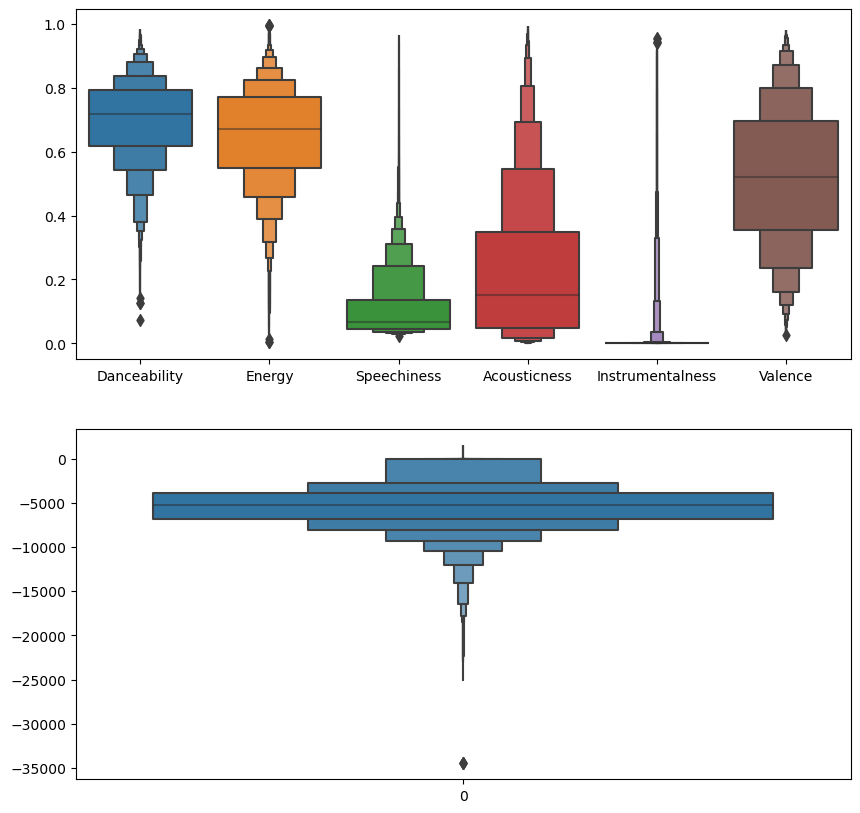

In [202]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.boxenplot(df_main_features.drop(columns="Loudness"), orient="y")

plt.subplot(212)
sns.boxenplot(df["Loudness"],orient="y")

In [205]:
def plotManyHist(df):
    for i in range(len(df.columns)):
        plt.figure(figsize=(15, 4))
        feature = df.columns[i]
        sns.histplot(data=df[feature], bins=100)
        plt.show()

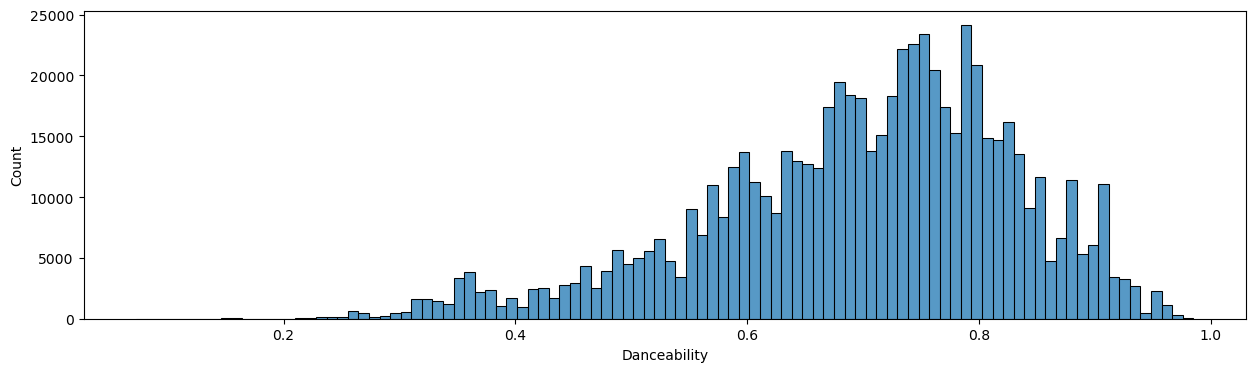

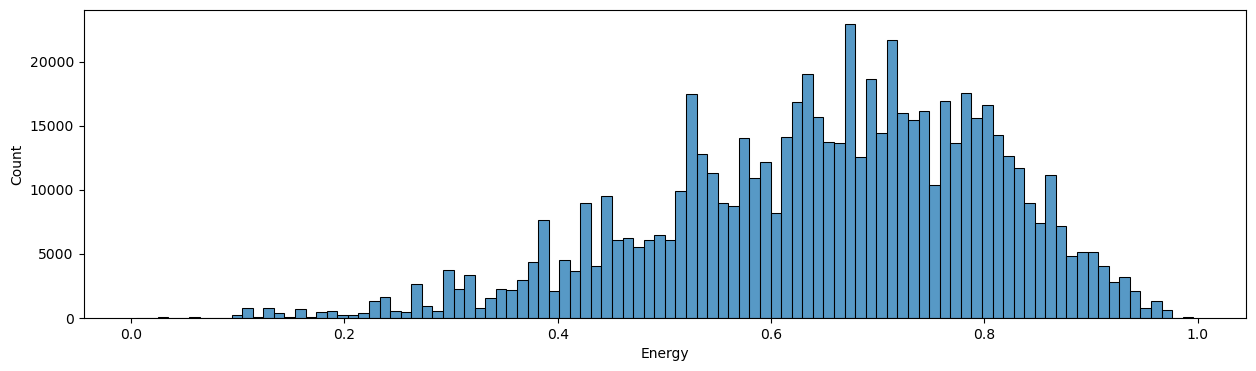

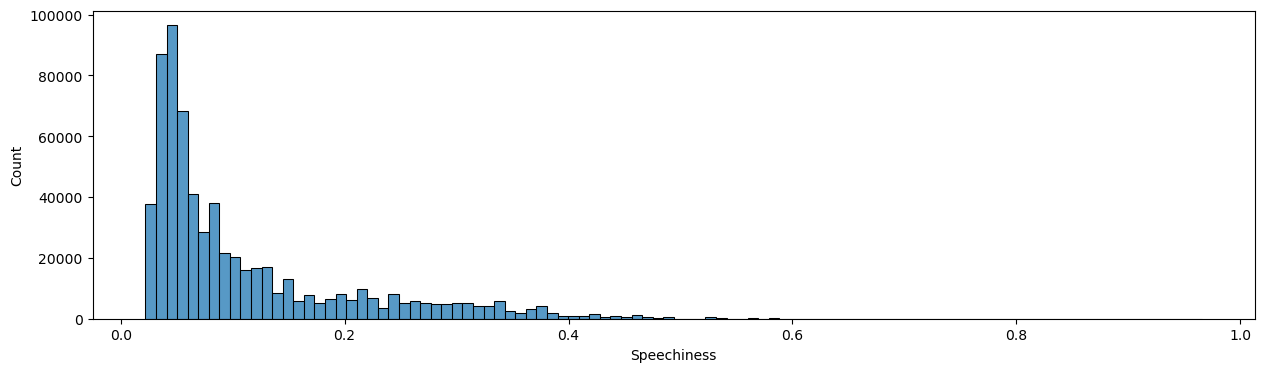

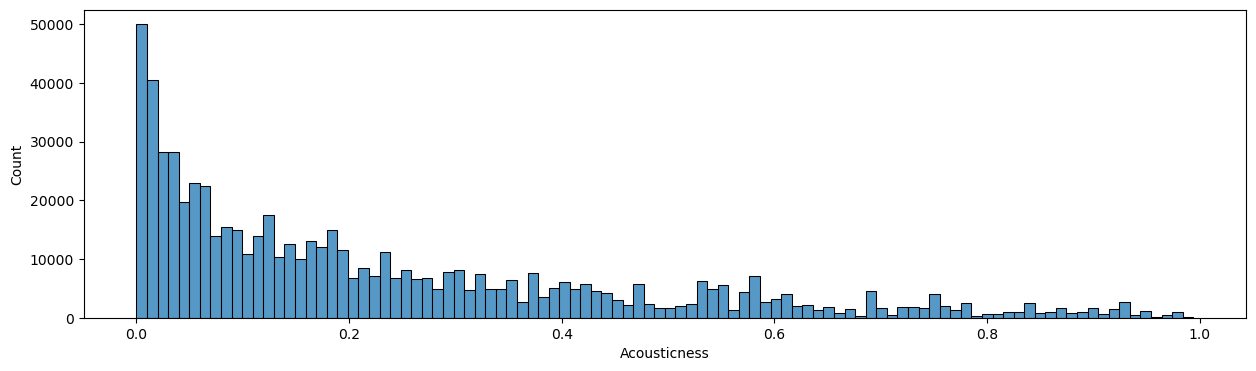

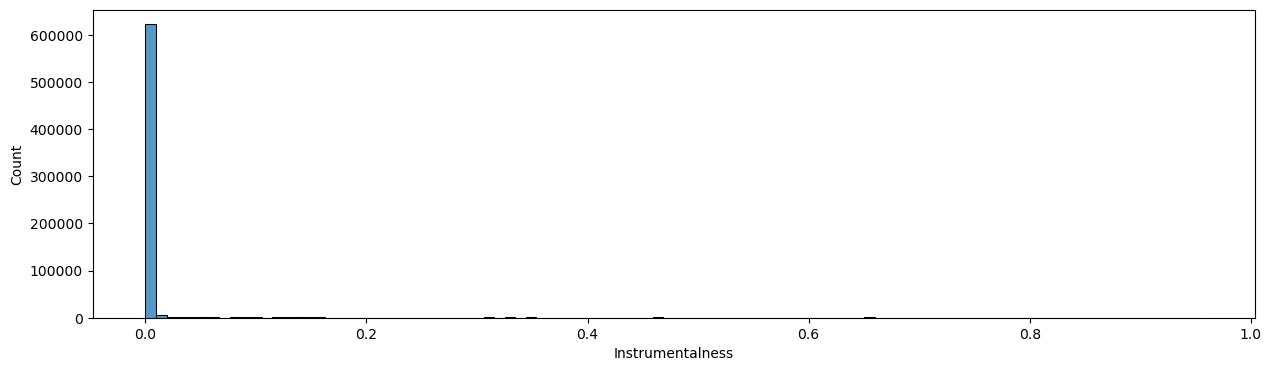

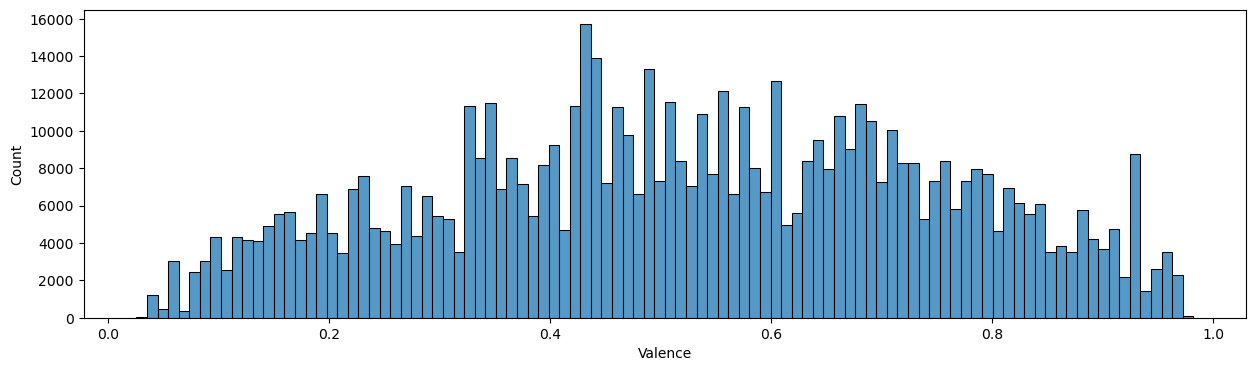

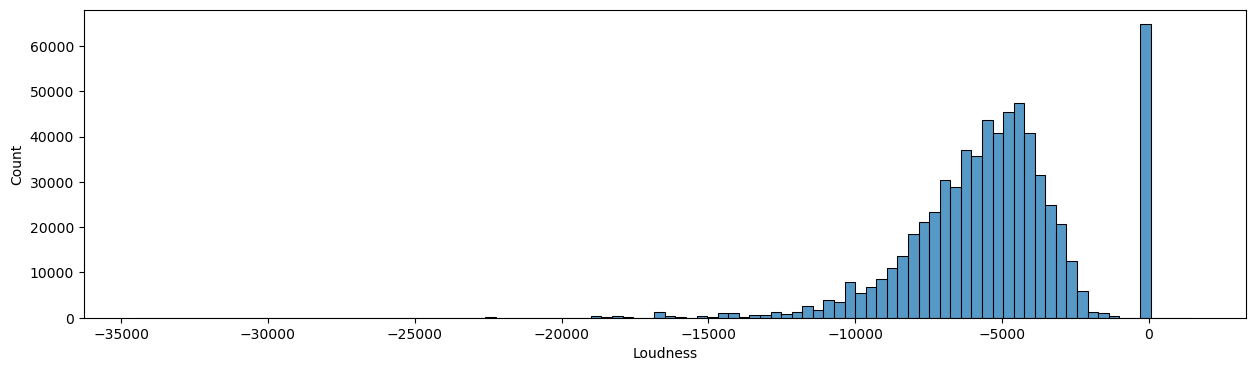

In [206]:
plotManyHist(df_main_features)

## Data Cleaning

In [207]:
df_features[df_features["Loudness"] > -1000]["Loudness"].min()

-31.16

In [208]:
# 1. Remove Loundness that values higher that -1000
loundness_outlier_mask = df_main_features["Loudness"] > -1000
df_features_clean_loudness = df_main_features[~loundness_outlier_mask].copy()

In [209]:
# 2. Remove outliers using IQR, outliers = out of this range [Q1-1.5IQR, Q3+1.5IQR]
lower_quantile = 0.25
upper_quantile = 0.75

lower_bounds = df_features_clean_loudness.quantile(lower_quantile)
upper_bounds = df_features_clean_loudness.quantile(upper_quantile)
iqr15 = (upper_bounds - lower_bounds) * 1.5

outliers = ((df_features_clean_loudness < (lower_bounds - iqr15)) | 
            (df_features_clean_loudness > (upper_bounds + iqr15))).any(axis=1)
df_clean = (df_features[~loundness_outlier_mask])[~outliers].copy()
df_clean.describe()

,Danceability,Energy,Speechiness,Acousticness,Instrumentalness,Valence,Loudness,Month,Points (Total)
count,440551.000000,440551.000000,440551.000000,440551.000000,440551.0,440551.000000,440551.000000,440551.000000,440551.000000
mean,0.703243,0.671961,0.087215,0.205741,0.0,0.541592,-5460.692335,6.238483,101.824095
std,0.119385,0.135547,0.060133,0.194434,0.0,0.218812,1746.572042,3.461685,57.533828
min,0.356000,0.230000,0.022000,0.000000,0.0,0.036000,-11144.000000,1.000000,1.000000
25%,0.628000,0.574000,0.044000,0.050000,0.0,0.385000,-6621.000000,3.000000,52.000000
50%,0.719000,0.681000,0.062000,0.143000,0.0,0.537000,-5276.000000,6.000000,103.000000
75%,0.790000,0.780000,0.112000,0.307000,0.0,0.710000,-4183.000000,9.000000,151.000000
max,0.985000,0.996000,0.271000,0.795000,0.0,0.982000,-1167.000000,12.000000,200.000000


In [229]:
# 3. drop Instrumentalness?
df_clean.drop(columns=['Instrumentalness'], inplace=True)

In [230]:
# 4. Normalize loudness?
# scaler = MinMaxScaler() 
# df_clean["Loudness"] = (df_clean["Loudness"]-df_clean["Loudness"].min())/df_clean["Loudness"].std()

In [231]:
print(df_features.shape, "->", df_clean.shape)

(651936, 10) -> (440551, 9)


### - Visualise cleaned data

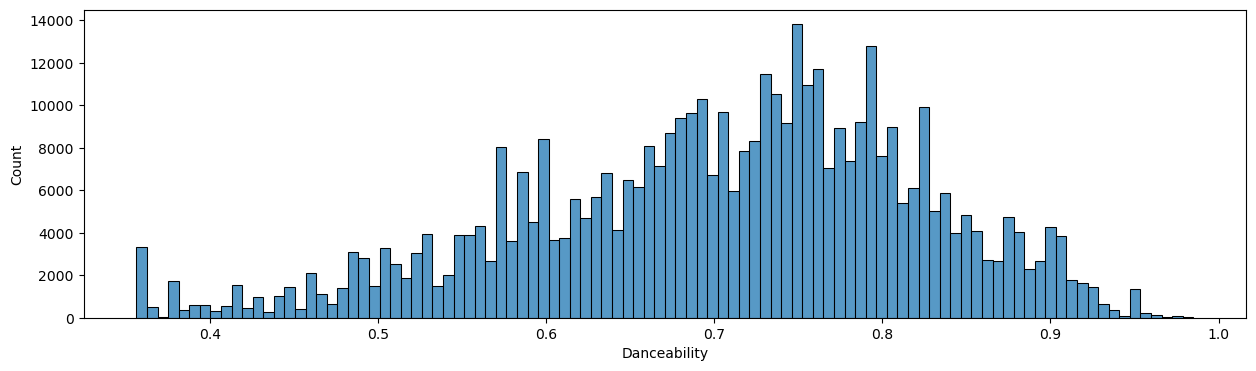

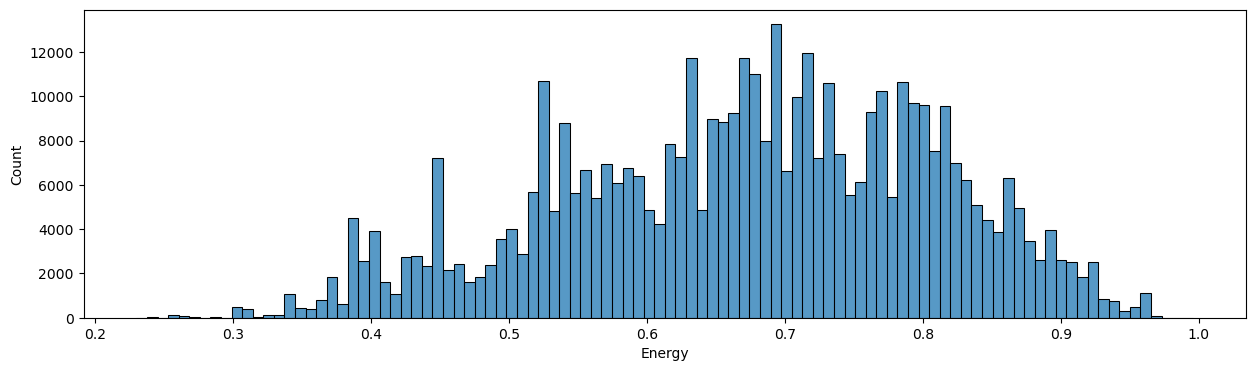

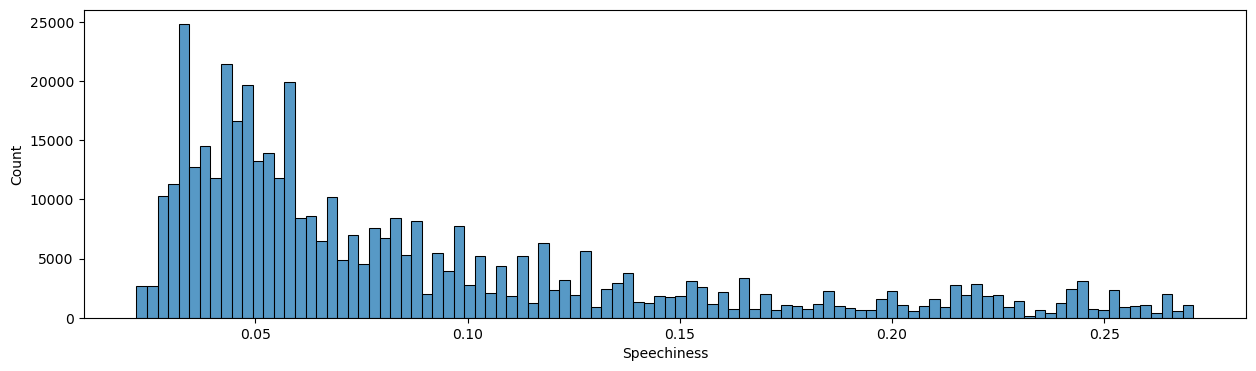

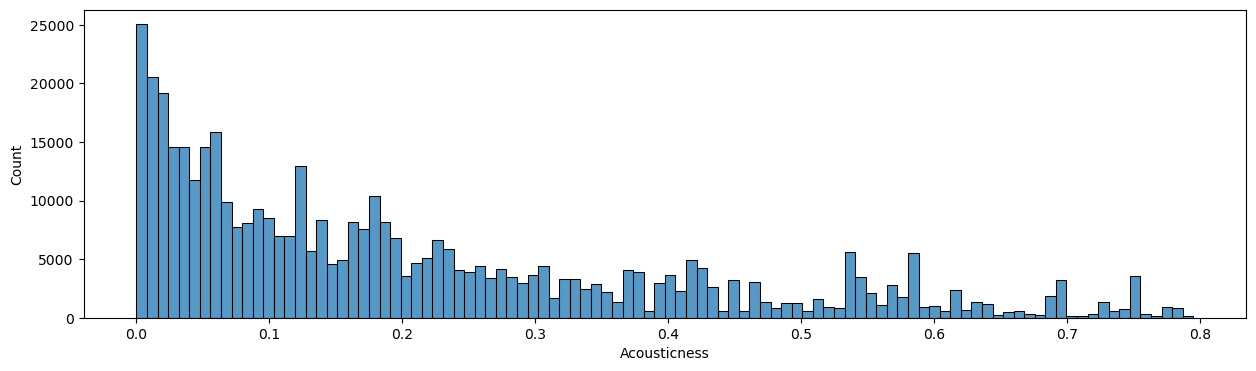

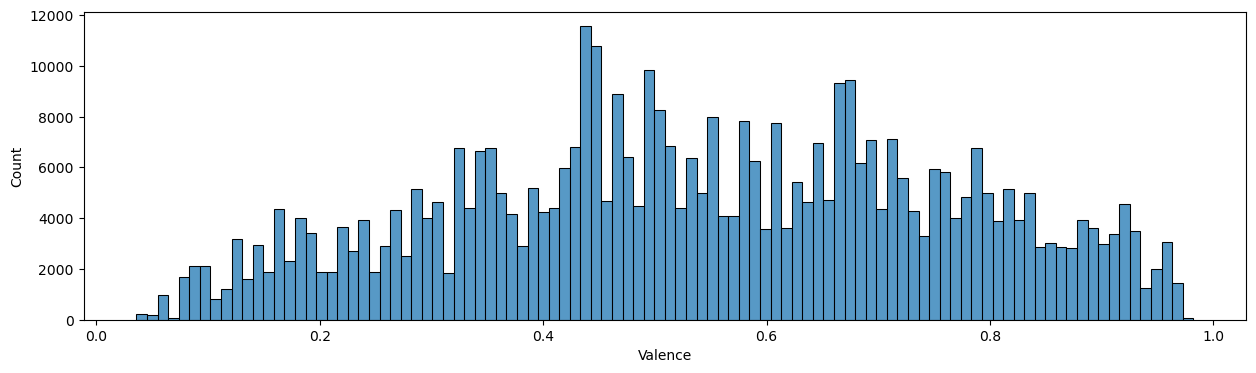

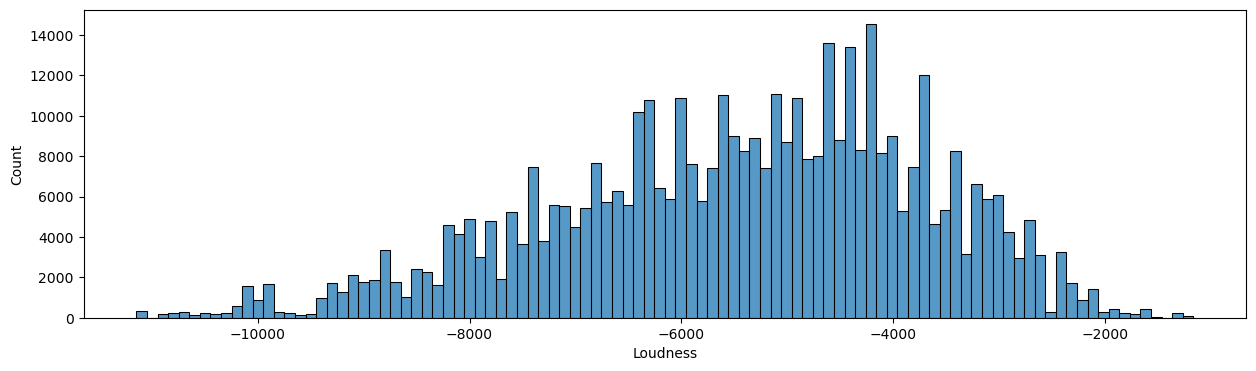

In [232]:
plotManyHist(df_clean.drop(columns=['Month', 'Day_in_week', 'Points (Total)']))

<Axes: >

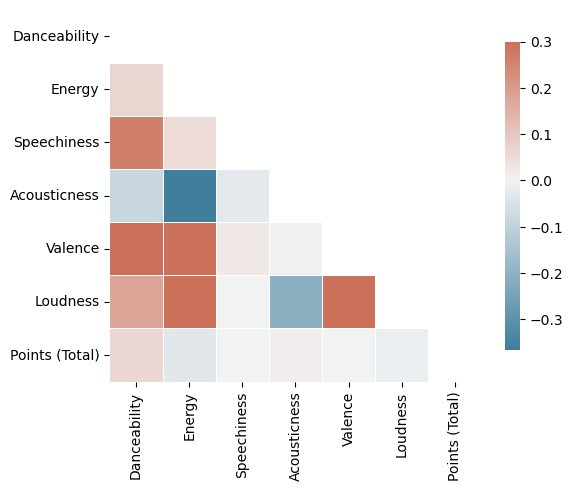

In [233]:
corr = df_clean.drop(columns=["Month", "Day_in_week"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# may use "abs(corr)"
sns.heatmap((corr), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

<Axes: xlabel='Loudness', ylabel='Valence'>

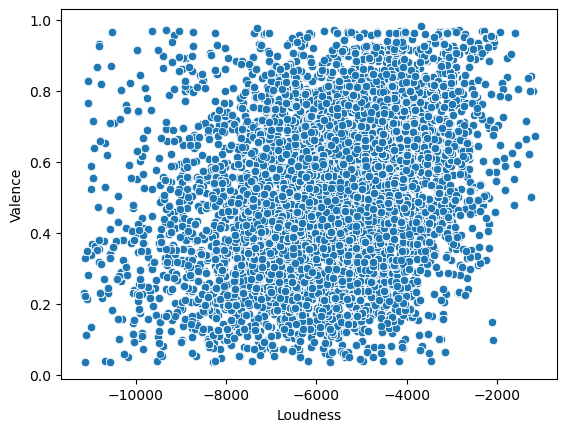

In [234]:
sns.scatterplot(data=df_clean, x="Loudness", y="Valence")

### - Corr btw features & Points (Total) filtered by day in week

In [288]:
df_raw["Day_in_week"].unique()

array(['Monday', 'Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday',
       'Tuesday'], dtype=object)

In [289]:
df_raw = df_clean.drop(columns=["Month"]).copy()
df_corr_day = pd.DataFrame()

for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    df_corr = df_raw[df_raw["Day_in_week"] == day].drop(columns="Day_in_week").corr()
    df_corr_day[day] = df_corr[["Points (Total)"]].T.drop(columns="Points (Total)").iloc[0]

df_corr_day

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Danceability,0.054682,0.056340,0.057587,0.062096,0.053478,0.059091,0.055192
Energy,-0.030265,-0.029945,-0.030657,-0.031379,-0.033849,-0.037516,-0.036140
Speechiness,-0.006282,-0.002806,-0.002400,-0.000066,-0.000970,-0.001034,-0.002214
Acousticness,0.013465,0.012306,0.014276,0.014406,0.005062,0.003895,0.006402
Valence,0.000208,-0.000927,-0.000845,0.001570,-0.010204,-0.008388,-0.008897
Loudness,-0.011285,-0.010933,-0.010385,-0.009770,-0.015184,-0.012803,-0.013505


Text(0.5, 101.00793650793652, 'Point')

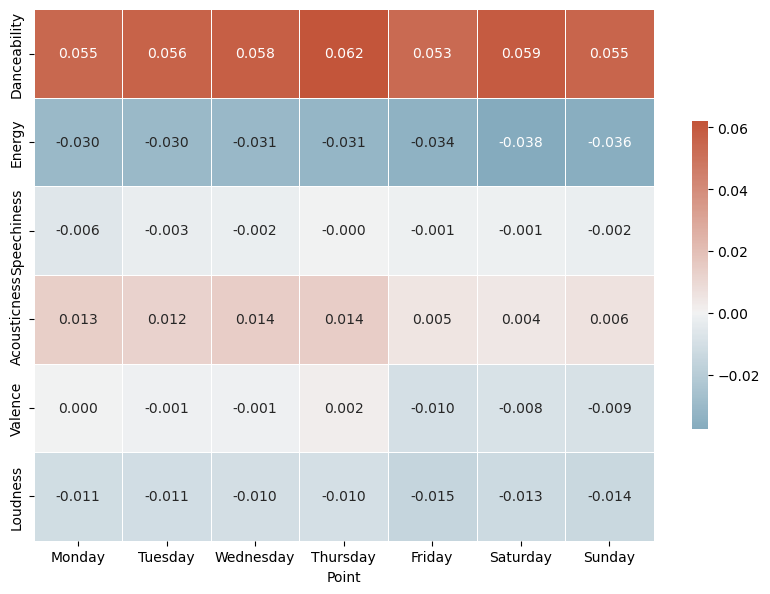

In [290]:
# Draw the heatmap
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap((df_corr_day), cmap=cmap, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')

plt.xlabel("Point")

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
# sns.heatmap(ax=axes[0], data=df_corr_day[["Monday"]], cmap=cmap, center=0, square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')
# sns.heatmap(ax=axes[1], data=df_corr_day[["Tuesday"]], cmap=cmap, center=0, square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')
# sns.heatmap(ax=axes[2], data=df_corr_day[["Wednesday"]], cmap=cmap, center=0, square=True,
#             linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.3f')

## Clustering (Draft)

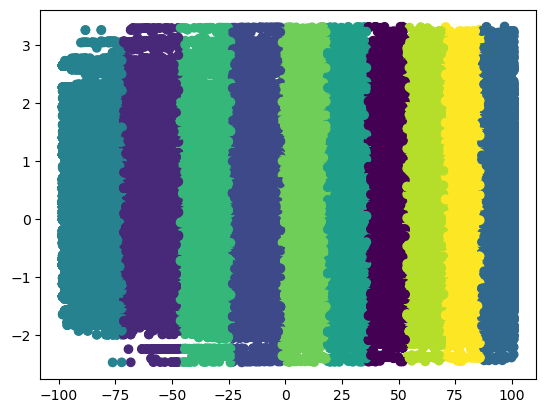

In [148]:
df_cluster_original = df_clean.drop(columns=["Day_in_week", "Month"]).copy()
# df_cluster_original = df_main_features.copy()

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
kmeans.fit(df_cluster_original)

df_cluster = df_cluster_original.copy()
df_cluster['cluster'] = kmeans.labels_
labels = kmeans.labels_

pca = PCA(n_components=4)  # Reduce to 2 dimensions
X_2d = pca.fit_transform(df_cluster_original)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')

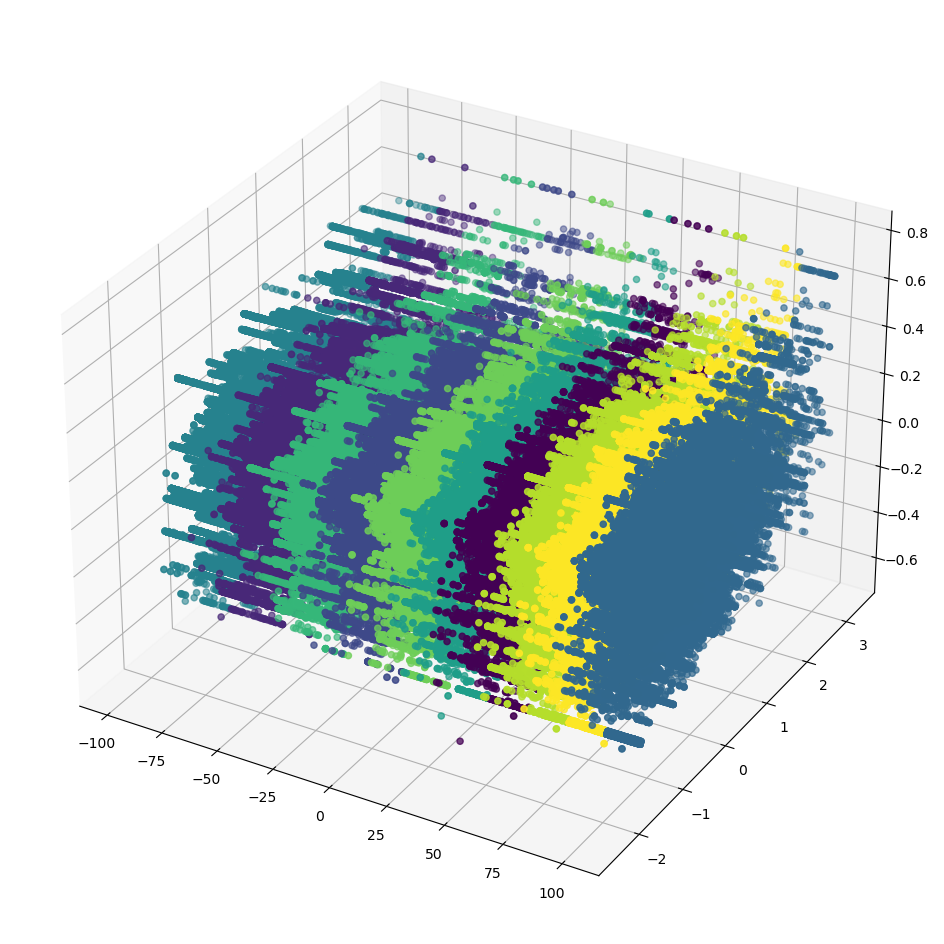

In [147]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_2d[:, 0], X_2d[:, 1], X_2d[:, 2], c=labels)
plt.show()

## Explore data for each cluster

In [254]:
# Filter songs based on a specific cluster
pd.options.display.max_colwidth = 100
df.filter(items=df_cluster[df_cluster["cluster"] == 3].index, axis=0)

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Day_in_week,Month
274,186,I AM,IVE,2023-05-29,0.683,0.875,-4866.0,0.055,0.012,0.0,...,IVE,Nationality 1,South Korea,Asia,15,15.0,70t7Q6AYG6ZgTYmJWcnkUM,https://open.spotify.com/track/70t7Q6AYG6ZgTYmJWcnkUM,Monday,5
277,189,Shut up My Moms Calling,Hotel Ugly,2023-05-29,0.485,0.409,-10711.0,0.101,0.325,0.0,...,Hotel Ugly,Nationality 1,United States,Anglo-America,12,12.0,3hxIUxnT27p5WcmjGUXNwx,https://open.spotify.com/track/3hxIUxnT27p5WcmjGUXNwx,Monday,5
278,190,Lover,Taylor Swift,2023-05-29,0.359,0.543,-7582.0,0.092,0.492,0.0,...,Taylor Swift,Nationality 1,United States,Anglo-America,11,11.0,1dGr1c8CrMLDpV6mPbImSI,https://open.spotify.com/track/1dGr1c8CrMLDpV6mPbImSI,Monday,5
279,191,Demons,Imagine Dragons,2023-05-29,0.505,0.710,-3015.0,0.032,0.190,0.0,...,Imagine Dragons,Nationality 1,United States,Anglo-America,10,10.0,5qaEfEh1AtSdrdrByCP7qR,https://open.spotify.com/track/5qaEfEh1AtSdrdrByCP7qR,Monday,5
280,192,Shivers,Ed Sheeran,2023-05-29,0.788,0.859,-2724.0,0.086,0.281,0.0,...,Ed Sheeran,Nationality 1,United Kingdom,Europe,9,9.0,3xWGA8pa0IKFI7IMPri4P0,https://open.spotify.com/track/3xWGA8pa0IKFI7IMPri4P0,Monday,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651929,195,Taped up Heart (feat. Clara Mae),KREAM,2017-01-01,0.675,0.937,-3525.0,0.051,0.152,0.0,...,KREAM,Nationality 1,Norway,Europe,6,6.0,26hcyzSE154xMZCbFdtInA,https://open.spotify.com/track/26hcyzSE154xMZCbFdtInA,Sunday,1
651930,196,White Iverson,Post Malone,2017-01-01,0.675,0.562,-7678.0,0.035,0.233,0.0,...,Post Malone,Nationality 1,United States,Anglo-America,5,5.0,6eT7xZZlB2mwyzJ2sUKG6w,https://open.spotify.com/track/6eT7xZZlB2mwyzJ2sUKG6w,Sunday,1
651933,199,Secrets,The Weeknd,2017-01-01,0.665,0.771,-5779.0,0.053,0.016,0.0,...,The Weeknd,Nationality 1,Canada,Anglo-America,2,2.0,3DX4Y0egvc0slLcLl31h2p,https://open.spotify.com/track/3DX4Y0egvc0slLcLl31h2p,Sunday,1
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,-6125.0,0.248,0.076,0.0,...,JAY-Z,Nationality 1,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O,https://open.spotify.com/track/2KpCpk6HjXXLb7nnXoXA5O,Sunday,1


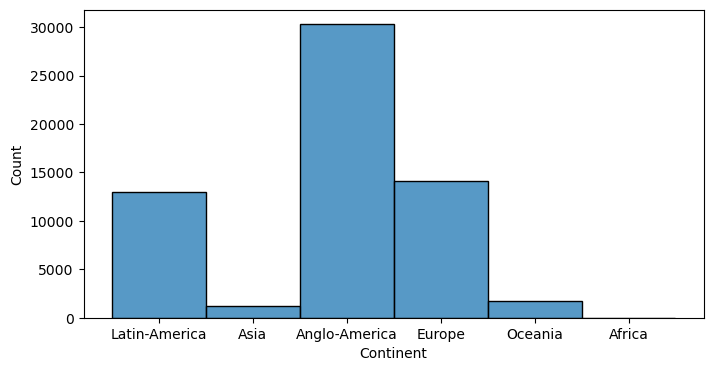

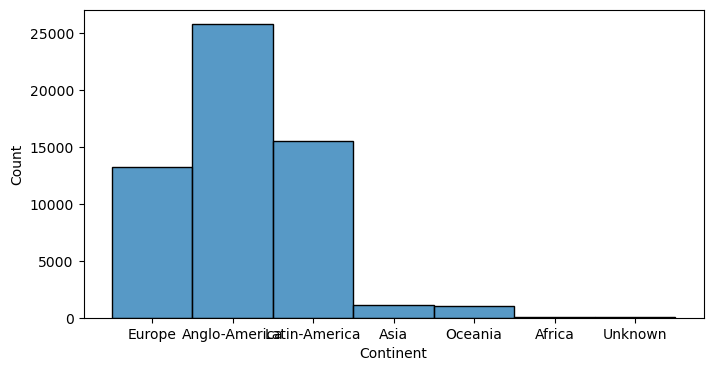

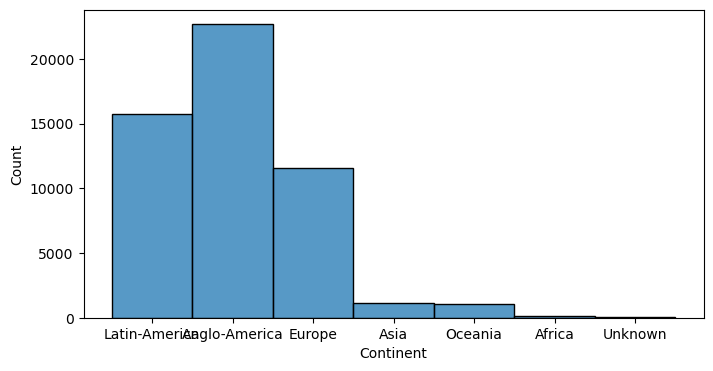

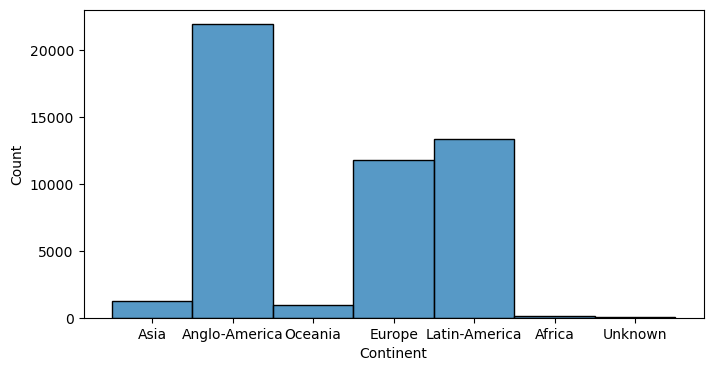

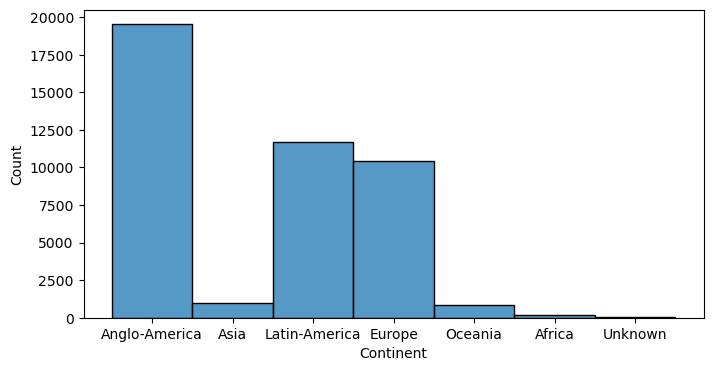

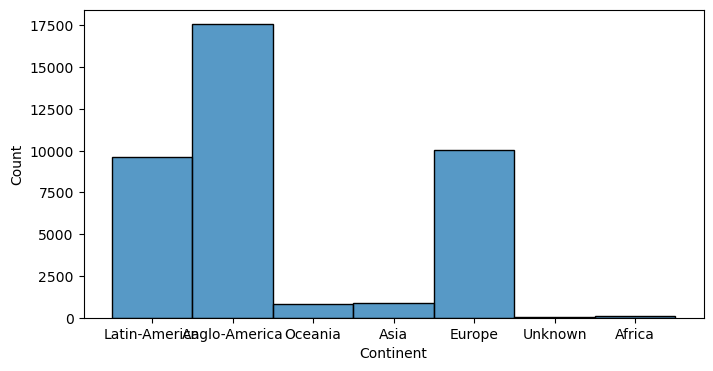

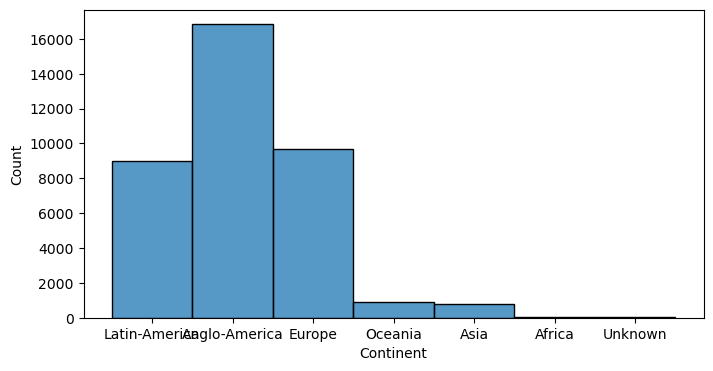

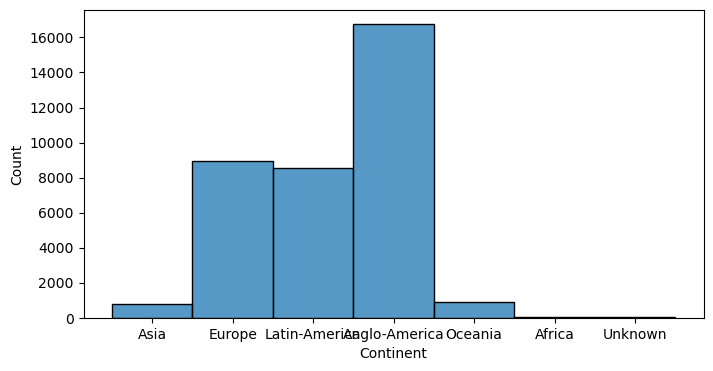

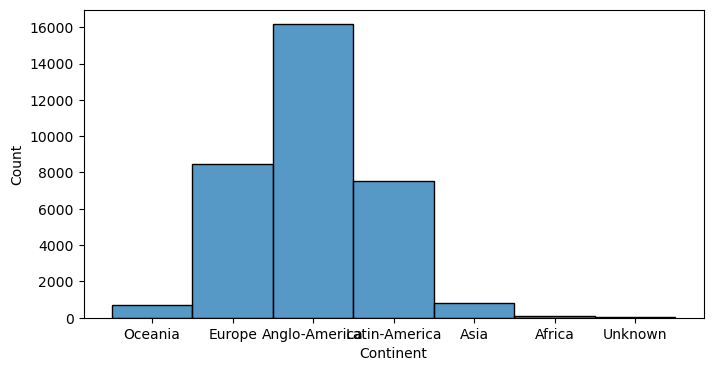

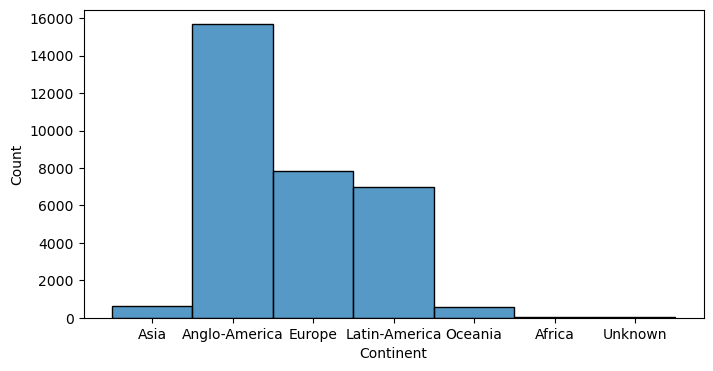

In [196]:
for cluster in df_cluster["cluster"].unique():
    plt.figure(figsize=(8,4))
    sns.histplot(df.filter(items=df_cluster[df_cluster["cluster"] == cluster].index, axis=0)["Continent"])
    plt.show()